## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#append path with python modules
import importlib
import sys
sys.path.append("../modules")
sys.path.append("/home/akalinow/scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

2024-03-15 09:51:54.048089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 09:51:54.048173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 09:51:54.119487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Dane w postaci pary macierzy `x,y` są mało wydajne w sytuacji gdy jest ich dużo lub są rozmieszczone w wielu plikach.
TF dostarcza dedykowaną klasę do obsługi strumienia wejścia:
```Python
tf.data.Dataset(variant_tensor)
```

Klasa `tf.Dataset` pozwala na zaawansowane operacje na danych. Implementacja tych operacji korzysta równoległego przetwarzania danych w celu zwiększenia przepustowości strumienia wejścia: `liczby przykładów na sekundę`.



Obiekt `tf.Dataset` można tworzyć na wiele sposobów:

* z macierzy:

```Python
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
```

* z funkcji typu generator

```Python
dataset = tf.data.Dataset.from_generator(...)
```

* z pliku typu CSV

```Python
dataset = tf.data.TextLineDataset(...)
```

* z pliku zawierającego dane w dedykowanym formacie `TFRecord`

```Python
dataset = tf.data.TFRecordDataset(["file1.tfrecords", "file2.tfrecords"])
```



Konstrukcja `tf.data.Dataset` z macierzy NumPy

In [145]:
nExamples = 5
nFeatures = 3
epsilon = 0.01
x = tf.random.uniform((nExamples, nFeatures), minval=-1, maxval=1, dtype=tf.float32, name="features")
y = tf.math.reduce_sum(x**2, axis=1)
y = tf.reshape(y, (-1, 1))

print(colored("Features shape:", "blue"), x.shape)
print(colored("Labels shape:", "blue"), y.shape)

dataset = tf.data.Dataset.from_tensor_slices((x, y))
print(dataset)
print(colored("Dataset lenght:", "blue"), len(dataset))

Features shape: (5, 3)
Labels shape: (5, 1)
<_TensorSliceDataset element_spec=(TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>
Dataset lenght: 5


`tf.Dataset` zachowuje się jak kolekcja - można po niej iterować łatwo dostosowując liczbę analizowanych elementów i punkt startowy:

In [146]:
print(colored("Iteration over the full dataset", "blue"))
for item in dataset:
    print(item)

print(colored("Iteration over n elements", "blue"))
n = 3
for item in dataset.take(n):
    print(item)

print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item)    

Iteration over the full dataset
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.83148456,  0.94676304,  0.25903463], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.6548258], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.0381639 , -0.80448294, -0.90269494], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4635074], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.97016597,  0.76058364, -0.6039171 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.8844254], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7396879 , 0.38492155, 0.26239967], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.76415646], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.5556493 , -0.29076624, -0.8658991 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.1430724], dtype=float32)>)
Iteration over 

Konstrukcja `tf.Dataset` z funkcji generującej.

W tym wypadku oprócz funkcji generującej musimy podać informacje o kształcie i typie danych generowanych przez funkcję:
```Python
dataset = tf.data.Dataset.from_generator(
         generator,                                      # funkcja generująca
         output_signature=(                              # opis kształtu i typu
             (tf.TensorSpec(shape=(3), dtype=tf.float32),# danych generowanych
             tf.TensorSpec(shape=(1), dtype=tf.int32)))  # przez funkcję
    )
```

In [8]:
#Generator function definition
nFeatures = 3

def points3DGenerator():
    while True:
        x = tf.random.uniform(shape=(nFeatures,), minval=0.1, maxval=1, dtype=tf.float32, name="features")
        y = tf.math.reduce_sum(x**2, axis=0)
        y = tf.reshape(y, (1))
        yield x,y

#Dataset from generator
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )


In [3]:
print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item) 

Iteration over n elements starting from m
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.6233151 , -0.4184518 ,  0.10133147], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5738917], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.41458917,  0.19169283, -0.28073788], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.28744408], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.96736693, 0.15211177, 0.00283337], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9589448], dtype=float32)>)


Na zbiorze `tf.Dataset` można wykonywać różne operacje przekształcenia:

```Python
dataset = dataset.repeat(n) - # powtarza dane n razy
                              # W sytuacji gdy nie podano argumentu
                              # dane są powtarzane w nieskończoność.
```

**Uwaga:** nie trzeba używać `repeat` by uzyskać wiele epok w czasie treningu. Funkcja `model.fit(...)` 
sama zarządza wielokrotnymi przejściami przez zbiór danych

```Python
dataset = dataset.batch(n)   - # grupowanie zbioru w paczki. 
                               # W czasie treningu paczki są automatycznie 
                               # rozpoznane i nie trzeba (nie wolno) podawać 
                               # rozmiaru paczki explicite. 
```



In [154]:
dataset_batched = dataset.batch(2)

#Access a single example (batch in this case)
it = iter(dataset_batched)
print(colored("Features shape:", "blue"), next(it)[0].numpy().shape)
print(colored("Labels shape:", "blue"), next(it)[1].numpy().shape)

print(colored("Iteration over n elements starting from m", "blue"))
n = 1
for item in dataset_batched.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Features shape: (2, 3)
Labels shape: (2, 1)
Iteration over n elements starting from m
	Labels: [[0.04409266 0.5604167  0.5226462 ]
 [0.5621605  0.84780884 0.02476478]]
	Features: [[0.5891701]
 [1.0354177]]


Zbiór danych można poddać też ogólnej transformacji zmieniającej zawartość poszczególnych wierszy:
```Python
dataset_transformed = dataset.map(func) # func to funkcja przyjmująca dany wiersz i zwracająca nowy
```

In [4]:
def func(features, label):
    return features**2, label

dataset_transformed = dataset.map(func)

print(colored("Iteration over original dataset", "blue"))
for item in dataset.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

print(colored("Iteration over transformed dataset", "blue"))
for item in dataset_transformed.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Iteration over original dataset
	Labels: [-0.2108655   0.1856246   0.81335163]
	Features: [0.7404616]
	Labels: [ 0.8499749  -0.5065186  -0.15776491]
	Features: [1.0039082]
	Labels: [0.9615724  0.79651475 0.38250065]
	Features: [1.705364]
Iteration over transformed dataset
	Labels: [0.11093152 0.59676737 0.0087232 ]
	Features: [0.7164221]
	Labels: [0.13896605 0.57933754 0.15911496]
	Features: [0.8774185]
	Labels: [9.0645044e-05 3.5114956e-04 4.5555793e-02]
	Features: [0.04599759]


**Proszę:**

* skopiować funkcję `discGenerator` z poprzednich zajęć
* stworzyć zbiór `tf.Dataset` obrazów kół korzystając bezpośredni z generatora. Prosze przyjąć rozdzielczość 256 $\times$ 256

In [167]:
#BEGIN_SOLUTION
res = 256

def discGenerator():

    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label

dataset = tf.data.Dataset.from_generator(discGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(3), dtype=tf.int32),
             tf.TensorSpec(shape=(res,res,1), dtype=tf.int32)))
    )
#END_SOLUTION

item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (3,)
Labels shape: (256, 256, 1)


**Proszę:**

* napisać funkcję `reading_benchmark(dataset)` która przyjmuje zbiór danych, iteruje po całym zbiorze i oblicza i 
   wypisuje na ekran swój czas wykonania
* w iteracjach po elementach zbioru proszę wstawić krótki postój:
```Python
time.sleep(1E-10)
```
* proszę wywołać funkcję na zbiorze który ma $10^{4}$ elementów i zarejestrować czas przebiegu po zbiorze

In [157]:
#BEGIN_SOLUTION
import time

def reading_benchmark(dataset):
    start_time = time.perf_counter()
    for sample in dataset:
        # Performing a training step
        time.sleep(1E-10)
    tf.print("Execution time: {:3.2f} s".format(time.perf_counter() - start_time))


reading_benchmark(dataset.take(int(1E4)))    
#END_SOLUTION    

Execution time: 12.88 s


Generacja danych za każdym razem kiedy jest wywoływana iteracja po zbiorze jest kosztowana - 
lepiej wygenerować dane raz i je zapisać w pamięci podręcznej. To samo dotyczy zbiorów czytanych z dysku i 
poddawanych kosztownym operacjom przekształcania. Zapisywanie zbioru w tymczasowym pliku można uzyskać przez metodę `cache`:
```Python
dataset_cached = dataset.cache()
```

**Proszę:**

* wywołać dwa razy funkcję `reading_benchmark` na zbiorze `dataset_cached`
* czy jest jakaś różnica w czasie wykonania?
* jeśli tak, to skąd się ona bierze?

In [158]:
#BEGIN_SOLUTION
dataset_cached = dataset.take(int(1E4)).cache()

print(colored("First pass", "blue"))
reading_benchmark(dataset_cached)
print(colored("Second pass", "blue"))
reading_benchmark(dataset_cached)
#END_SOLUTION

First pass
Execution time: 13.57 s
Second pass
Execution time: 1.88 s


Każdy wiersz danych w postaci `tf.Dataset` powinien zawierać cechy i etykiety by mozna go było przekazać do funkcji trenującej model:
```Python
model.fit(dataset, ...)  #Podajemy tylko tf.Dataset. 
                         #Metoda model.fit(...) sama rozkłada każdy wiersz na cechy i etykiety
```

Jeśli `tf.Dataset` pochodzi z generatora, jako dane walidacyjne najlepiej podać nowy zbiór. 
W tej sytuacji trzeba także podać liczbę przykładów dla obu zbiorów:

```Python
model.fit(dataset.batch(batchSize).take(nStepsPerEpoch),
          epochs=nEpochs, 
          validation_data=dataset.batch(batchSize).map(mapFunc).take(100))
```

**Proszę:**

* wytrenować model obliczający kwadrat odległości punktu od środka układu współrzędnych
* jako zbiorów uczacego, walidacyjnego i testowego proszę użyć obiektów `tf.Dataset` wypełnionych z użyciem generatora
* proszę narysować historię treningu
* proszę obliczyć ułamek przykładów ze zbioru testowego dla którego wynik modelu różni się od etykiety o nie więcej niż 1%

Epoch 1/64
8192/8192 [==============================] - 183s 22ms/step - loss: 2.9808 - val_loss: 2.0466
Epoch 2/64
8192/8192 [==============================] - 31s 4ms/step - loss: 0.7269 - val_loss: 0.7942
Epoch 3/64
8192/8192 [==============================] - 29s 4ms/step - loss: 0.3195 - val_loss: 0.1886
Epoch 4/64
8192/8192 [==============================] - 31s 4ms/step - loss: 0.2086 - val_loss: 0.1999
Epoch 5/64
8192/8192 [==============================] - 28s 3ms/step - loss: 0.1782 - val_loss: 0.1676
Epoch 6/64
8192/8192 [==============================] - 28s 3ms/step - loss: 0.1689 - val_loss: 0.1647
Epoch 7/64
8192/8192 [==============================] - 30s 4ms/step - loss: 0.1652 - val_loss: 0.1638
Epoch 8/64
8192/8192 [==============================] - 30s 4ms/step - loss: 0.1641 - val_loss: 0.1632
Epoch 9/64
8192/8192 [==============================] - 30s 4ms/step - loss: 0.1636 - val_loss: 0.1627
Epoch 10/64
8192/8192 [==============================] - 32s 4ms/step -

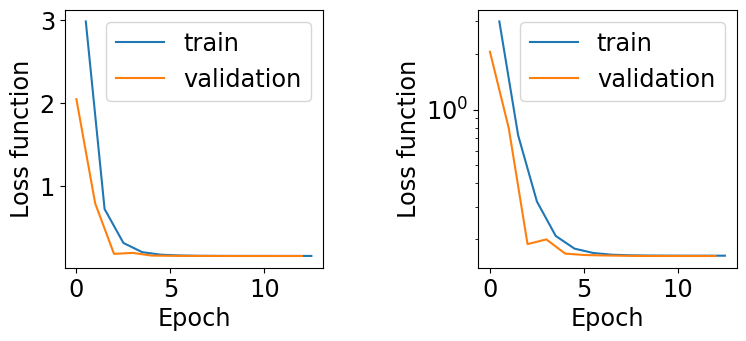

In [9]:
#Dataset from generator
##BEGIN_SOLUTION
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )
##END_SOLUTION

#Model definition
#BEGIN_SOLUTION
def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):
   
    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = inputs
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                                  name="layer_"+str(iLayer))(x)
                
    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)   
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model
#END_SOLUTION
#################
#Model training
#BEGIN_SOLUTION
nEpochs = 64
nStepsPerEpoch = 128
batchSize = 32

initial_learning_rate = 1E-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*3,
                decay_rate=0.95,
                staircase=True)

model = getModel(inputShape=(nFeatures,), nNeurons = np.full((8),128), 
                 hiddenActivation="relu", 
                 outputActivation="linear", 
                 nOutputNeurons=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.MeanAbsolutePercentageError(),
            metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=1E-3)
callbacks = [early_stop_callback]
    
dataset_cached = dataset.batch(batchSize).map(func).take(nStepsPerEpoch*nEpochs).cache()
history = model.fit(dataset_cached,
                    epochs=nEpochs, 
                    validation_data=dataset_cached.take(batchSize*4),
                    callbacks=callbacks,
                    verbose=1)

model.evaluate(dataset_cached.take(16))
plf.plotTrainHistory(history)
#END_SOLUTION
#################
#Model evaluation
dataset_test = dataset.batch(128).take(16)
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y - y_pred)/y
pull = pull.flatten()
threshold = 1E-2

print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.2f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))

Fraction of examples with abs(pull)<0.01: 0.00
Pull standard deviation: 1.82
16/16 [==============================] - 0s 3ms/step - loss: 0.1633


0.1633441001176834

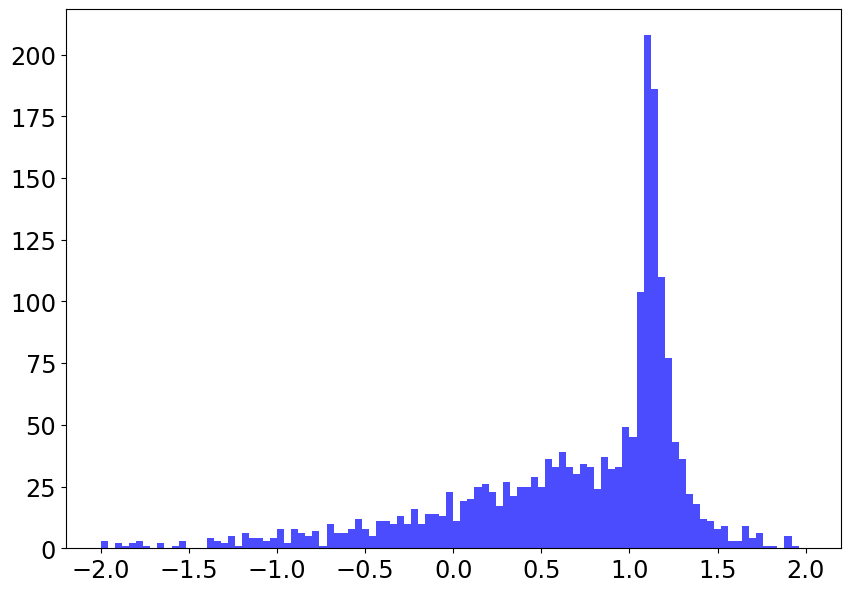

In [7]:
plt.hist(pull, bins=100, range=(-2, 2), color='b', alpha=0.7, label='Pull');
print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.2f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))
model.evaluate(dataset_cached.take(16))

**Proszę:**

* przeprowadzić trening z zadania domowego z notatnika 07 używając `tf.Dataset` w optymalnej konfiguracji ze względu na czas przetwarzania zbioru
* porównać czas treningu z czasem treningu na danych zadanych w postaci macierzy numpy 

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 


 conv2d_52 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 4, 4, 1)           129       
                                                                 
Total params: 18945 (74.00 KB)
Trainable params: 18945 (74.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_60 (Conv2  (None, 8, 8, 32)          320       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_61 (C

2024-03-14 14:57:01.212611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


FileNotFoundError: [Errno 2] No such file or directory: 'fig_png/training_history.png'

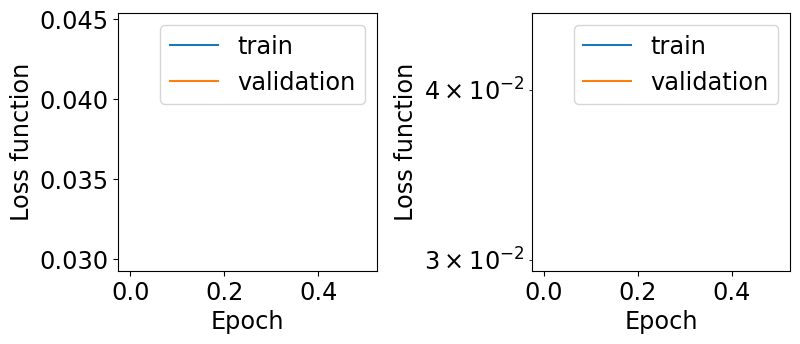

In [168]:
%%time

#Model definition
encoder = tf.keras.Sequential(layers = [tf.keras.Input(shape=(256,256,1)),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='relu')],
                                         name='encoder')
encoder.summary()

decoder =  tf.keras.Sequential(layers = [tf.keras.Input(shape=(4,4,1)),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                         tf.keras.layers.Conv2D(filters=1, kernel_size=2, strides=1, padding='same', activation='sigmoid')],
                                name="decoder")
decoder.summary()

model_cnn_ae = tf.keras.Sequential([encoder, decoder], name="autoencoder")
model_cnn_ae.build(input_shape=(256,256,1))
model_cnn_ae.summary()

###Training
nEpochs = 200
initial_learning_rate = 1E-3
batchSize = 32
    
nStepsPerEpoch = int(1024/batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

def mapFunc(x, y):
    return y, y                

model = model_cnn_ae
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy')
    
#run training
datset_cached = dataset.batch(batchSize).map(mapFunc).take(nStepsPerEpoch*nEpochs).cache()
history = model.fit(dataset_cached,
                    epochs=1, 
                    validation_data=dataset.batch(batchSize).map(mapFunc).take(100).cache(),
                    verbose=0)
    
plf.plotTrainHistory(history)

#Evaluation
#plotDecoded(model_cnn_ae)



In [165]:
dataset_cached = dataset.batch(batchSize).map(mapFunc).take(nStepsPerEpoch*nEpochs).cache()

print(colored("First pass", "blue"))
reading_benchmark(dataset_cached)
print(colored("Second pass", "blue"))
reading_benchmark(dataset_cached)

First pass
Execution time: 1.07 s
Second pass
Execution time: 0.09 s


2024-03-14 14:45:16.398155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 536870912 bytes after encountering the first element of size 536870912 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-14 14:45:16.579414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 536870912 bytes after encountering the first element of size 536870912 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


In [161]:
nStepsPerEpoch*nEpochs

6400

In [137]:
dataset_1 = dataset.batch(batchSize).map(lambda x, y: y)

x = next(iter(dataset_1))
print(colored("Features shape:", "blue"), x.shape)

Features shape: (32, 256, 256, 1)


# Zadanie domowe

